In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [8]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def area_type(row):
    if row >= 0:
        return 1
    else:
        return 0

In [4]:
train_Y = np.log1p(Train_data['total_price'])
ids = Test_data['building_id']

tp = copy.deepcopy(np.log1p(Train_data['total_price']))

Train_data = Train_data.drop(['building_id', 'total_price'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

df = pd.concat([Train_data,Test_data])

df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [5]:
na_check(df)

,Missing Ratio
parking_area,94.852857
parking_price,76.821429
txn_floor,26.487143
village_income_median,1.894286


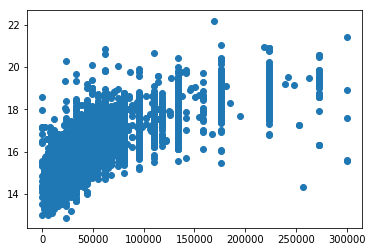

In [6]:
df.loc[:, "parking_price"] = df["parking_price"].clip(0.1, 300000)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_price"], train_Y)

In [7]:
parking_price = df['parking_price']
parking_area = df['parking_area']

df = df.drop(['parking_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price

In [8]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

In [9]:
XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

[23:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,58,1,157,1,2483,1,6011,1,34.469803,5.480033
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,28,1,115,1,15872,1,32221,1,40.073573,10.412824
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,78,1,212,1,15760,1,32228,1,54.462081,10.463612
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,20,1,125,1,2568,1,7271,1,99.628966,11.303930
4,1,21,20657,2,4,2,6880,2,5.393906,61.306524,...,18,1,47,1,2587,1,7442,1,124.131236,8.313252


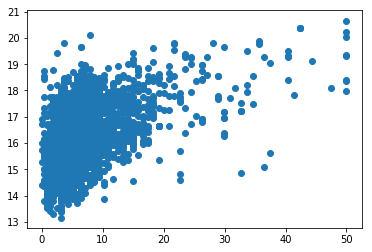

In [10]:
df['parking_area'] = parking_area
df.loc[:, "parking_area"] = df["parking_area"].clip(0.1, 50)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_area"], train_Y)

In [11]:
park_area_not_null = df[df['parking_area'].notnull()]
park_area_is_null = df[df['parking_area'].isnull()].drop(['parking_area'] , axis=1)

park_area_X = park_area_not_null.drop(['parking_area'] , axis=1)
park_area_Y = park_area_not_null['parking_area']

In [12]:
XGBR = xgb.XGBRegressor()
XGBR.fit(park_area_X, park_area_Y)

park_area_pred = XGBR.predict(park_area_is_null)

df.loc[df['parking_area'].isnull(), 'parking_area'] = park_area_pred

df.head()

[23:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,1,157,1,2483,1,6011,1,34.469803,5.480033,4.197453
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,1,115,1,15872,1,32221,1,40.073573,10.412824,2.721138
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,1,212,1,15760,1,32228,1,54.462081,10.463612,2.302792
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,1,125,1,2568,1,7271,1,99.628966,11.303930,6.734877
4,1,21,20657,2,4,2,6880,2,5.393906,61.306524,...,1,47,1,2587,1,7442,1,124.131236,8.313252,0.088575


In [143]:
df = df.drop(['parking_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())

In [6]:
temp_df = copy.deepcopy(df)

In [14]:
temp_df = temp_df.fillna(temp_df.mean())

temp_df["txn_dt"] = temp_df["txn_dt"]/100
temp_df["building_complete_dt"] = temp_df["building_complete_dt"]/100

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])
temp_df["building_area"] = temp_df["building_area"].clip(1, 50)
temp_df["land_area"] = temp_df["land_area"].clip(1, 50)
temp_df["town_area"] = temp_df["town_area"].clip(1, 150)

temp_df["per_building_area"] = temp_df["building_area"] / temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]
temp_df["per_parking_price"] = np.log1p(np.expm1(temp_df["parking_price"]) / temp_df["parking_area"])
temp_df["education_rate"] = temp_df["jobschool_rate"] + temp_df["highschool_rate"]

temp_df["area_diff"] = temp_df["land_area"] - temp_df["building_area"]
temp_df['area_type'] = temp_df['area_diff'].apply(area_type)
#temp_df = temp_df.drop(['area_diff'] , axis=1)

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

/home/rex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


In [15]:
temp_df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_MIN,parking_price,parking_area,per_building_area,total_income,area_percent,per_parking_price,education_rate,area_diff,area_type
0,8,21,186.74,4,3,2,62.71,2,3.000000,18.144460,...,34.469803,5.480033,4.197453,0.854544,11.943494,12.812980,4.058798,0.429944,14.726285,1
1,8,7,188.00,5,1,2,78.85,2,5.000000,11.387227,...,40.073573,10.412824,2.721138,0.808262,15.062772,0.492159,9.411825,0.417768,7.345919,1
2,8,7,192.89,4,1,2,60.28,2,1.000000,21.426802,...,54.462081,10.463612,2.302792,1.396070,15.082789,0.926072,9.629527,0.417768,15.842523,1
3,8,21,203.85,24,0,2,183.25,0,13.000000,11.387227,...,99.628966,11.303930,6.734877,0.565126,13.769437,0.771895,9.396701,0.429944,-2.175803,0
4,1,21,206.57,2,4,2,68.80,2,5.393906,50.000000,...,124.131236,8.313252,0.088575,2.344054,13.468119,0.703829,10.736937,0.429944,45.311892,1


In [16]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]

temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city", "building_type", "building_use", "total_floor", "txn_floor"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [17]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,town,lat,lon,village_income_median,...,area_percent,per_parking_price,education_rate,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,334,-39.14,117.08,6.350886,...,12.812980,4.058798,0.429944,14.726285,1,14.763179,15.617864,15.495543,15.608550,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,180,-37.66,119.28,6.311735,...,0.492159,9.411825,0.417768,7.345919,1,15.734002,15.368964,15.495543,15.399266,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,180,-37.67,119.29,6.439350,...,0.926072,9.629527,0.417768,15.842523,1,15.734002,15.368964,15.495543,15.608550,15.786106
3,8,203.85,183.25,0,11.387227,13.563031,343,-39.13,117.09,6.857514,...,0.771895,9.396701,0.429944,-2.175803,0,14.763179,15.837634,15.495543,16.127585,15.839771
4,1,206.57,68.80,2,50.000000,4.688108,102,-39.24,117.19,6.285998,...,0.703829,10.736937,0.429944,45.311892,1,14.763179,15.429428,15.495543,14.954292,15.429428


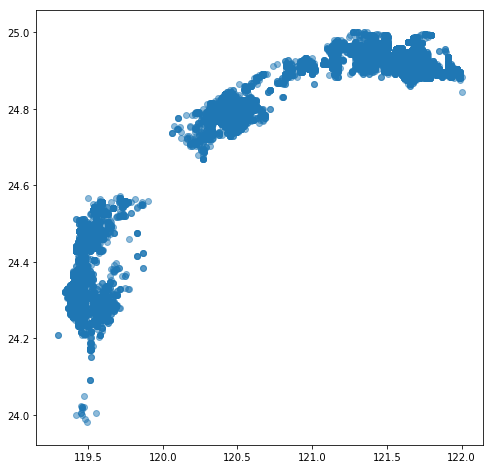

In [17]:
# make geo_df
geo = copy.deepcopy(temp_df)
geo["lat"] = geo["lat"] + 100
geo["lat"] = (geo["lat"]/geo["lat"].max())*25
geo["lon"] = (geo["lon"]/geo["lon"].max())*122

geo_df = geo[['lat', 'lon']]
#temp_df['lon'] = temp_df['lon']# / 1e6
#temp_df['lat'] = temp_df['lat'] #/ 1e6

x = np.array(geo_df['lon'])
y = np.array(geo_df['lat'])

fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.5)
plt.show()

In [18]:
temp_df["lat"] = geo["lat"]
temp_df["new_location"] = (geo["lat"]*geo["lon"])/100

In [26]:
train_X = temp_df[:train_num]

estimator = xgb.XGBRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=temp_df.columns)
feats = feats.sort_values(ascending=False)

[23:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
feats[feats!=0]

jobschool_rate           0.152990
parking_price            0.152448
master_rate              0.094858
XIII_10000               0.075765
city_mean                0.056486
building_area            0.051398
VII_10000                0.045858
doc_rate                 0.032301
XIII_5000                0.029522
village_income_median    0.022164
per_building_area        0.018874
X_5000                   0.016091
XII_1000                 0.015688
III_10000                0.015075
land_area                0.013445
area_percent             0.011623
V_500                    0.011378
V_10000                  0.010757
VII_1000                 0.010576
XI_10000                 0.008681
V_5000                   0.008484
per_parking_price        0.007948
total_income             0.006678
I_10000                  0.006103
XII_10000                0.006100
XII_5000                 0.005622
building_type_mean       0.005596
lon                      0.005579
VII_250                  0.005282
building_compl

In [28]:
temp_df = temp_df.fillna(temp_df.mean())
train_X = temp_df[:train_num]

est = RandomForestRegressor()
est.fit(train_X, train_Y)
feats_est = pd.Series(data=est.feature_importances_, index=temp_df.columns)
feats_est = feats_est.sort_values(ascending=False)

In [29]:
feats_est[feats_est!=0]

parking_price            4.190458e-01
building_area            3.484740e-01
per_building_area        1.948225e-02
jobschool_rate           1.493199e-02
XIII_10000               1.347781e-02
land_area                1.067104e-02
parking_area             9.742176e-03
master_rate              9.544578e-03
city_mean                8.076653e-03
lon                      7.419916e-03
building_complete_dt     7.354028e-03
txn_dt                   5.367696e-03
V_10000                  4.707845e-03
village_income_median    4.363579e-03
VII_10000                4.120314e-03
junior_rate              4.107279e-03
XIII_5000                3.833649e-03
txn_floor_mean           3.686726e-03
area_diff                3.358517e-03
per_parking_price        3.278559e-03
XIV_5000                 2.988614e-03
total_income             2.963786e-03
XII_1000                 2.343904e-03
VII_1000                 2.342797e-03
parking_way              2.280093e-03
doc_rate                 2.169132e-03
VI_10000    

In [37]:
high_feature = list(set(feats[feats!=0].index)&set(feats_est[feats_est!=0].index))

high_feature
    

['building_area',
 'V_5000',
 'III_MIN',
 'XII_10000',
 'III_1000',
 'XIII_10000',
 'parking_area',
 'XIV_5000',
 'IX_500',
 'IX_50',
 'X_250',
 'city_mean',
 'N_50',
 'II_10000',
 'X_5000',
 'lat',
 'X_MIN',
 'IV_1000',
 'txn_floor_mean',
 'parking_way',
 'XI_10000',
 'XIV_500',
 'N_1000',
 'VII_10000',
 'X_500',
 'born_rate',
 'VI_5000',
 'VI_10000',
 'IV_MIN',
 'X_1000',
 'town',
 'building_type_mean',
 'XI_MIN',
 'I_1000',
 'VIII_500',
 'XIV_10000',
 'XI_1000',
 'VI_MIN',
 'VIII_250',
 'IV_500',
 'building_material',
 'town_population',
 'III_10000',
 'area_diff',
 'IX_5000',
 'VII_MIN',
 'txn_dt',
 'VIII_MIN',
 'II_250',
 'XIV_250',
 'per_building_area',
 'IX_1000',
 'total_income',
 'V_250',
 'I_5000',
 'V_10000',
 'doc_rate',
 'I_10000',
 'V_500',
 'land_area',
 'lon',
 'XII_5000',
 'town_population_density',
 'VII_500',
 'XIII_1000',
 'marriage_rate',
 'XIII_MIN',
 'master_rate',
 'jobschool_rate',
 'village_income_median',
 'per_parking_price',
 'building_complete_dt',
 'V_MIN

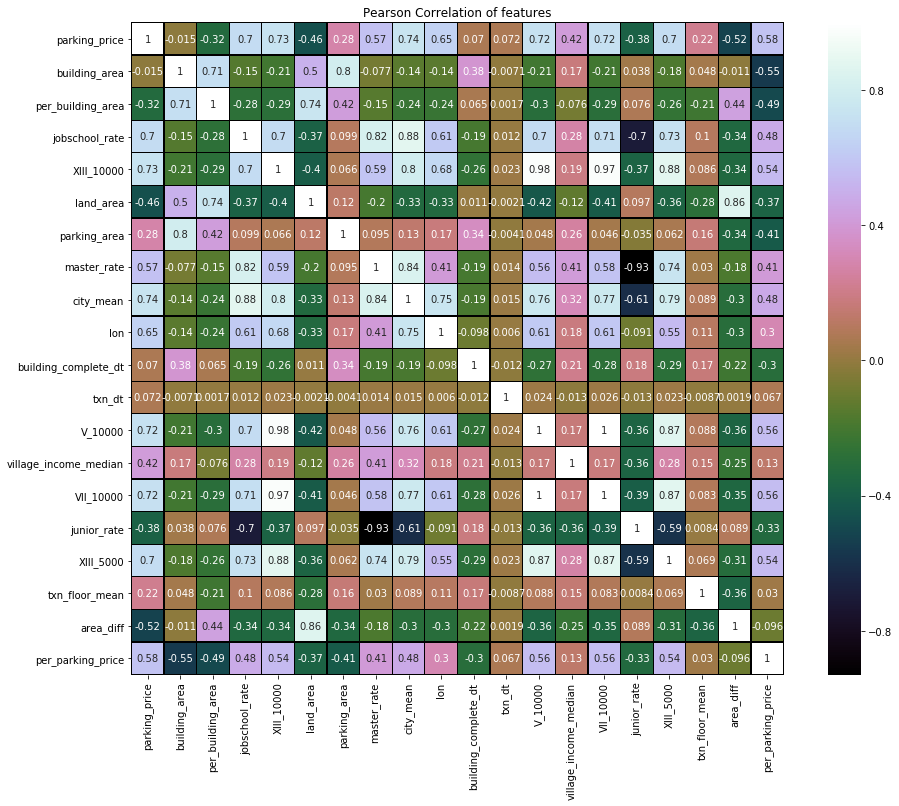

In [35]:
f, ax = plt.subplots(figsize=(16, 12)
plt.title('Pearson Correlation of features')
high_feature = list(feats_est[:20].index)
sns.heatmap(temp_df[high_feature].astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [41]:
#temp_df = temp_df.drop(['VI_10000'] , axis=1)
#temp_df = temp_df.drop(['master_rate'] , axis=1)
#temp_df = temp_df.drop(['XIII_5000'] , axis=1)
#temp_df = temp_df.drop(['area_diff'] , axis=1)

high_feature.remove('VI_10000')
high_feature.remove('master_rate')
high_feature.remove('XIII_5000')
high_feature.remove('area_diff')

In [42]:
#high_feature = list(feats_est[:50].index)
#high_feature = ["parking_price","building_area","per_building_area","XIII_10000",
#                "land_area","jobschool_rate","VII_10000","village_income_median"]

train_X = temp_df[:train_num][high_feature]
test_X = temp_df[train_num:][high_feature]

In [43]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

0.9358491836338644
Mean squared error: 0.0750


In [44]:
estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-06-24.csv",index=False)

In [65]:
def MAPE(object_, predict_):
    n = len(predict_)
    return sum(abs((predict_-object_)/object_))/n

def HitRate(object_, predict_):
    n = len(predict_)
    Z = [(p - o)/o for o,p in zip(object_, predict_)]
    Z = list(map(lambda x : 1 if x <= 0.1 else 0, Z))
        
    return sum(Z)/n

def Score(object_, predict_):
    if MAPE(object_, predict_)>=1:
        m = 1
    else:
        m = MAPE(object_, predict_)
        
    return (round(HitRate(object_, predict_), 4)*(10**4)) + (1-m)

In [159]:
Score(y_test, y_pred)

9993.98786355667